In [1]:
import re
import datetime
import itertools
import pickle
from collections import Counter

import pandas as pd
import numpy as np
import pymongo
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pymongo import MongoClient

import pyLDAvis
from wordcloud import WordCloud
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
from pyLDAvis import gensim
from scipy.spatial import distance

client = MongoClient("localhost", 27017)
db = client["reddit_polarization"]
sw = pickle.load(open("stoplist.pickle"))
sw.update(stopwords.words("english"))

In [2]:
import warnings
warnings.simplefilter('ignore')
    
from gensim import models
model = models.Doc2Vec.load("doc2vec_dbow_d100_n5_w15_mc5_s1e_05_t6.model")

In [3]:
X_men_specific_word, X_fem_specific_word = pickle.load(open("polar_words.pickle"))

In [4]:
X_men_specific_word.shape, X_fem_specific_word.shape

((500, 100), (500, 100))

In [80]:
men_posts = pd.DataFrame(list(db["MensRights"].find({}, {"date": 1, "created_utc": 1, "_id": 1})))
fem_posts = pd.DataFrame(list(db["Feminism"].find({}, {"date": 1, "created_utc": 1, "_id": 1})))

In [81]:
men_posts.shape, fem_posts.shape

((2452716, 3), (213100, 3))

In [82]:
men_posts = men_posts[men_posts["_id"].map(lambda x: str(x) in model.docvecs.doctags)]
fem_posts = fem_posts[fem_posts["_id"].map(lambda x: str(x) in model.docvecs.doctags)]

In [83]:
men_posts.shape, fem_posts.shape

((1334802, 3), (132789, 3))

In [84]:
men_posts = men_posts.sort_values("created_utc")
men_posts = men_posts.reset_index(drop=True)
men_posts = men_posts.set_index("date")

In [85]:
fem_posts = fem_posts.sort_values("created_utc")
fem_posts = fem_posts.reset_index(drop=True)
fem_posts = fem_posts.set_index("date")

In [86]:
common_dates = sorted(list(set(men_posts.index) & set(fem_posts.index)))

In [87]:
len(common_dates)

2148

In [148]:
def semantic_dist_between(date):
    if date.month == 1 and date.day == 1:
        print date
    
    l1 = men_posts.ix[men_posts.index == date, "_id"]
    l2 = fem_posts.ix[fem_posts.index == date, "_id"]
    
    X1 = np.array([model.docvecs[str(one_id)] for one_id in l1])
    X2 = np.array([model.docvecs[str(one_id)] for one_id in l2])
    
    return cosine_distances(X1, X2).mean()

In [192]:
a = map(lambda x: (x, semantic_dist_between(x)), common_dates)

2010-01-01 00:00:00
2011-01-01 00:00:00
2012-01-01 00:00:00
2013-01-01 00:00:00
2014-01-01 00:00:00
2015-01-01 00:00:00
2016-01-01 00:00:00


In [193]:
a = pd.DataFrame(a)
a.columns = ["date", "dist"]
a = a.set_index("date")

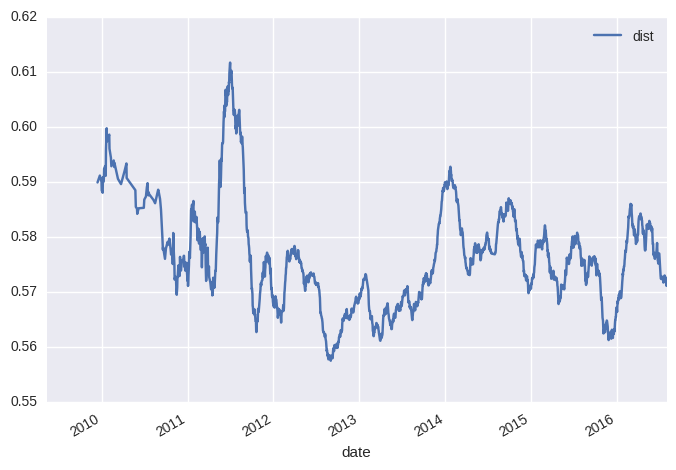

In [195]:
pd.rolling_mean(a, window=60).plot()
plt.show()

In [41]:
from sklearn.metrics.pairwise import paired_distances, cosine_distances

In [42]:
a = np.random.randint(1, 10, size=(5, 10))
b = np.random.randint(1, 10, size=(5, 10))

In [43]:
a

array([[1, 1, 8, 8, 7, 8, 7, 7, 1, 6],
       [4, 6, 6, 4, 2, 4, 6, 9, 3, 8],
       [9, 5, 9, 7, 8, 6, 2, 1, 5, 1],
       [4, 9, 5, 1, 4, 7, 8, 3, 3, 9],
       [2, 6, 3, 9, 5, 8, 3, 2, 3, 4]])

In [44]:
b

array([[6, 4, 9, 2, 3, 8, 9, 7, 9, 7],
       [4, 1, 8, 5, 4, 3, 1, 5, 5, 4],
       [8, 2, 9, 9, 6, 3, 4, 9, 5, 4],
       [1, 1, 5, 6, 3, 2, 6, 9, 9, 3],
       [6, 2, 5, 5, 6, 9, 1, 2, 6, 8]])

In [45]:
paired_distances(a, b)

array([ 12.489996  ,   9.79795897,  10.19803903,  15.3622915 ,   9.11043358])

In [46]:
np.linalg.norm(a[-1]- b[-1])

9.1104335791442992

In [56]:
distance.cosine(a[1], b[0])

0.094130805715259003

In [50]:
cosine_distances(a, b)

array([[ 0.17911698,  0.15197337,  0.1394859 ,  0.20811768,  0.19340306],
       [ 0.09413081,  0.1658082 ,  0.13916118,  0.17476609,  0.23322292],
       [ 0.23432378,  0.13193903,  0.13182227,  0.36079381,  0.14889693],
       [ 0.11858479,  0.31341799,  0.31974588,  0.3685975 ,  0.20526033],
       [ 0.26341228,  0.24195157,  0.22957187,  0.32143523,  0.14185156]])

In [17]:
common_dates[0]

Timestamp('2009-05-12 00:00:00')

In [18]:
semantic_dist_between(common_dates[0])

(43, 2)

In [45]:
radius = 5

def trend(row, df, center):

    date = row.name
    days = [date + datetime.timedelta(days=d) for d in range(-radius, radius)]

    ids = []
    
    for d in days:
        if d in df.index:
            ids.extend(list(df.ix[d, "ids"]))
    
    dist = [distance.cosine(model.docvecs[str(one_id)], center) for one_id in ids if str(one_id) in model.docvecs.doctags]
    
    if date.day == 1 and date.month == 1:
        print date
    
    return np.mean(dist)    
#            if author_groupby_day.ix[d, "men_author"] is not np.nan:
#                men_author.extend(list(author_groupby_day.ix[d, "men_author"]))
#            if author_groupby_day.ix[d, "fem_author"] is not np.nan:
#                fem_author.extend(list(author_groupby_day.ix[d, "fem_author"]))